## The Higgs to two photons analysis from the ATLAS Open Data 2020 release, with RDataFrame.

This tutorial is the Higgs to two photons analysis from the ATLAS Open Data release in 2020 (http://opendata.atlas.cern/release/2020/documentation/). The data was taken with the ATLAS detector during 2016 at a center-of-mass energy of 13 TeV. Although the Higgs to two photons decay is very rare, the contribution of the Higgs can be seen as a narrow peak around 125 GeV because of the excellent reconstruction and identification efficiency of photons at the ATLAS experiment.

The analysis is translated to a RDataFrame workflow processing 1.7 GB of simulated events and data.

In [2]:
import ROOT
import os
 
# Enable multi-threading
ROOT.ROOT.EnableImplicitMT()

In [3]:
# Create a ROOT dataframe for each dataset
path = "root://eospublic.cern.ch//eos/opendata/atlas/OutreachDatasets/2020-01-22"
df = {}
df["data"] = ROOT.RDataFrame("mini", (os.path.join(path, "GamGam/Data/data_{}.GamGam.root".format(x)) for x in ("A", "B", "C", "D")))
df["ggH"] = ROOT.RDataFrame("mini", os.path.join(path, "GamGam/MC/mc_343981.ggH125_gamgam.GamGam.root"))
df["VBF"] = ROOT.RDataFrame("mini", os.path.join(path, "GamGam/MC/mc_345041.VBFH125_gamgam.GamGam.root"))
processes = list(df.keys())

In [4]:
# Apply scale factors and MC weight for simulated events and a weight of 1 for the data
for p in ["ggH", "VBF"]:
    df[p] = df[p].Define("weight",
            "scaleFactor_PHOTON * scaleFactor_PhotonTRIGGER * scaleFactor_PILEUP * mcWeight");
df["data"] = df["data"].Define("weight", "1.0")

In [10]:
# Select the events for the analysis
for p in processes:
    # Apply preselection cut on photon trigger
    df[p] = df[p].Filter("trigP")
 
    # Find two good muons with tight ID, pt > 25 GeV and not in the transition region between barrel and encap
    df[p] = df[p].Define("goodphotons", "photon_isTightID && (photon_pt > 25000) && (abs(photon_eta) < 2.37) && ((abs(photon_eta) < 1.37) || (abs(photon_eta) > 1.52))").Filter("Sum(goodphotons) == 2")
 
    # Take only isolated photons
    df[p] = df[p].Filter("Sum(photon_ptcone30[goodphotons] / photon_pt[goodphotons] < 0.065) == 2").Filter("Sum(photon_etcone20[goodphotons] / photon_pt[goodphotons] < 0.065) == 2")

In [11]:
# Compile a function to compute the invariant mass of the diphoton system
ROOT.gInterpreter.Declare(
"""
using namespace ROOT;
float ComputeInvariantMass(RVecF pt, RVecF eta, RVecF phi, RVecF e) {
    ROOT::Math::PtEtaPhiEVector p1(pt[0], eta[0], phi[0], e[0]);
    ROOT::Math::PtEtaPhiEVector p2(pt[1], eta[1], phi[1], e[1]);
    return (p1 + p2).mass() / 1000.0;
}
""")

True

In [12]:
# Define a new column with the invariant mass and perform final event selection
hists = {}
for p in processes:
    # Make four vectors and compute invariant mass
    df[p] = df[p].Define("m_yy", "ComputeInvariantMass(photon_pt[goodphotons], photon_eta[goodphotons], photon_phi[goodphotons], photon_E[goodphotons])")
 
    # Make additional kinematic cuts and select mass window
    df[p] = df[p].Filter("photon_pt[goodphotons][0] / 1000.0 / m_yy > 0.35")\
                 .Filter("photon_pt[goodphotons][1] / 1000.0 / m_yy > 0.25")\
                 .Filter("m_yy > 105 && m_yy < 160")
 
    # Book histogram of the invariant mass with this selection
    hists[p] = df[p].Histo1D(
            ROOT.RDF.TH1DModel(p, "Diphoton invariant mass; m_{#gamma#gamma} [GeV];Events", 30, 105, 160),
            "m_yy", "weight")


In [13]:
# Run the event loop
 
# RunGraphs allows to run the event loops of the separate RDataFrame graphs
# concurrently. This results in an improved usage of the available resources
# if each separate RDataFrame can not utilize all available resources, e.g.,
# because not enough data is available.
ROOT.RDF.RunGraphs([hists[s] for s in ["ggH", "VBF", "data"]])
 
ggh = hists["ggH"].GetValue()
vbf = hists["VBF"].GetValue()
data = hists["data"].GetValue()
 
# Create the plot
 
# Set styles
ROOT.gROOT.SetStyle("ATLAS")

In [14]:
# Create canvas with pads for main plot and data/MC ratio
c = ROOT.TCanvas("c", "", 700, 750)
 
upper_pad = ROOT.TPad("upper_pad", "", 0, 0.35, 1, 1)
lower_pad = ROOT.TPad("lower_pad", "", 0, 0, 1, 0.35)
for p in [upper_pad, lower_pad]:
    p.SetLeftMargin(0.14)
    p.SetRightMargin(0.05)
    p.SetTickx(False)
    p.SetTicky(False)
upper_pad.SetBottomMargin(0)
lower_pad.SetTopMargin(0)
lower_pad.SetBottomMargin(0.3)
 
upper_pad.Draw()
lower_pad.Draw()

In [15]:
# Fit signal + background model to data
fit = ROOT.TF1("fit", "([0]+[1]*x+[2]*x^2+[3]*x^3)+[4]*exp(-0.5*((x-[5])/[6])^2)", 105, 160)
fit.FixParameter(5, 125.0)
fit.FixParameter(4, 119.1)
fit.FixParameter(6, 2.39)
fit.SetLineColor(2)
fit.SetLineStyle(1)
fit.SetLineWidth(2)
data.Fit("fit", "0", "", 105, 160)

 FCN=19.9699 FROM HESSE     STATUS=NOT POSDEF     23 CALLS         158 TOTAL
                     EDM=4.97694e-13    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.43251e+04   7.20524e+01   2.24889e-02   4.08986e-09
   2  p1          -1.77722e+03   7.78153e-01   4.23723e-04  -6.03572e-07
   3  p2           1.15606e+01   5.36059e-03   2.75626e-06  -5.63464e-05
   4  p3          -2.56281e-02   2.66823e-05   6.11022e-09   1.22585e-02
   5  p4           1.19100e+02     fixed    
   6  p5           1.25000e+02     fixed    
   7  p6           2.39000e+00     fixed    


Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResu

In [16]:
# Draw data
upper_pad.cd()
data.SetMarkerStyle(20)
data.SetMarkerSize(1.2)
data.SetLineWidth(2)
data.SetLineColor(ROOT.kBlack)
data.SetMinimum(1e-3)
data.SetMaximum(8e3)
data.GetYaxis().SetLabelSize(0.045)
data.GetYaxis().SetTitleSize(0.05)
data.SetStats(0)
data.SetTitle("")
data.Draw("E")

In [17]:
# Draw fit
fit.Draw("SAME")
 
# Draw background
bkg = ROOT.TF1("bkg", "([0]+[1]*x+[2]*x^2+[3]*x^3)", 105, 160)
for i in range(4):
    bkg.SetParameter(i, fit.GetParameter(i))
bkg.SetLineColor(4)
bkg.SetLineStyle(2)
bkg.SetLineWidth(2)
bkg.Draw("SAME")

In [18]:
# Scale simulated events with luminosity * cross-section / sum of weights
# and merge to single Higgs signal
lumi = 10064.0
ggh.Scale(lumi * 0.102 / 55922617.6297)
vbf.Scale(lumi * 0.008518764 / 3441426.13711)
higgs = ggh.Clone()
higgs.Add(vbf)
higgs.Draw("HIST SAME")

In [20]:
# Draw ratio
lower_pad.cd()
 
ratiobkg = ROOT.TH1I("zero", "", 100, 105, 160)
ratiobkg.SetLineColor(4)
ratiobkg.SetLineStyle(2)
ratiobkg.SetLineWidth(2)
ratiobkg.SetMinimum(-125)
ratiobkg.SetMaximum(250)
ratiobkg.GetXaxis().SetLabelSize(0.08)
ratiobkg.GetXaxis().SetTitleSize(0.12)
ratiobkg.GetXaxis().SetTitleOffset(1.0)
ratiobkg.GetYaxis().SetLabelSize(0.08)
ratiobkg.GetYaxis().SetTitleSize(0.09)
ratiobkg.GetYaxis().SetTitle("Data - Bkg.")
ratiobkg.GetYaxis().CenterTitle()
ratiobkg.GetYaxis().SetTitleOffset(0.7)
ratiobkg.GetYaxis().SetNdivisions(503, False)
ratiobkg.GetYaxis().ChangeLabel(-1, -1, 0)
ratiobkg.GetXaxis().SetTitle("m_{#gamma#gamma} [GeV]")
ratiobkg.Draw("AXIS")

ratiosig = ROOT.TH1F("ratiosig", "ratiosig", 5500, 105, 160)
ratiosig.Eval(fit)
ratiosig.SetLineColor(2)
ratiosig.SetLineStyle(1)
ratiosig.SetLineWidth(2)
ratiosig.Add(bkg, -1)
ratiosig.Draw("SAME")
 
ratiodata = data.Clone()
ratiodata.Add(bkg, -1)
for i in range(1, data.GetNbinsX()):
    ratiodata.SetBinError(i, data.GetBinError(i))
ratiodata.Draw("E SAME")

Warning in <TROOT::Append>: Replacing existing TH1: zero (Potential memory leak).


In [21]:
# Add legend
upper_pad.cd()
legend = ROOT.TLegend(0.55, 0.55, 0.89, 0.85)
legend.SetTextFont(42)
legend.SetFillStyle(0)
legend.SetBorderSize(0)
legend.SetTextSize(0.05)
legend.SetTextAlign(32)
legend.AddEntry(data, "Data" ,"lep")
legend.AddEntry(bkg, "Background", "l")
legend.AddEntry(fit, "Signal + Bkg.", "l")
legend.AddEntry(higgs, "Signal", "l")
legend.Draw()

In [22]:
# Add ATLAS label
text = ROOT.TLatex()
text.SetNDC()
text.SetTextFont(72)
text.SetTextSize(0.05)
text.DrawLatex(0.18, 0.84, "ATLAS")
text.SetTextFont(42)
text.DrawLatex(0.18 + 0.13, 0.84, "Open Data")
text.SetTextSize(0.04)
text.DrawLatex(0.18, 0.78, "#sqrt{s} = 13 TeV, 10 fb^{-1}")

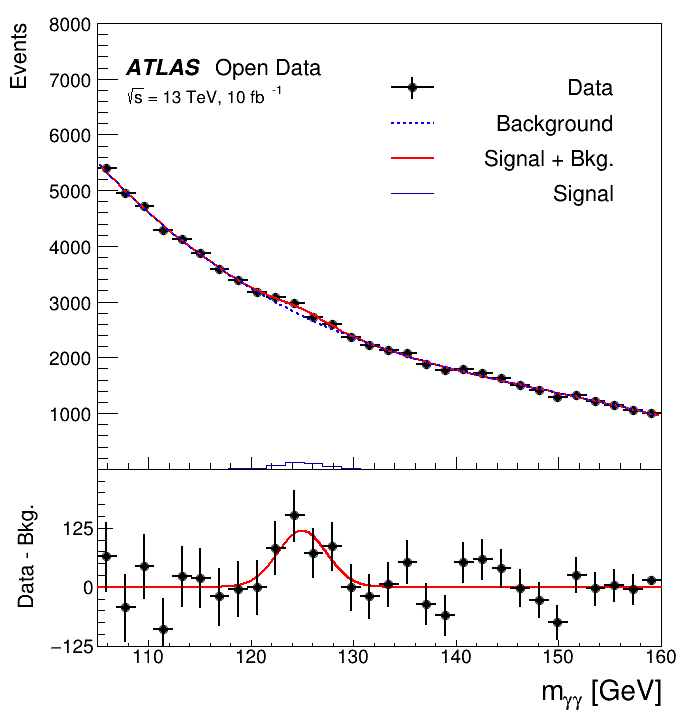

In [23]:
c.Draw()

In [25]:
c.SaveAs("HiggsToTwoPhotons.png")
print("Saved figure to HiggsToTwoPhotons.png")

Saved figure to HiggsToTwoPhotons.png


Info in <TCanvas::Print>: png file HiggsToTwoPhotons.png has been created
